# Garbage Classification using PyTorch

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


In this notebook we'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Let us see the classes present in the dataset:

In [2]:
directory  = 'C:/Users/legen/Eco_Bins/garbage_classification/all_classes/'

classes = os.listdir(directory)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(directory, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: plastic (Class No: 4)


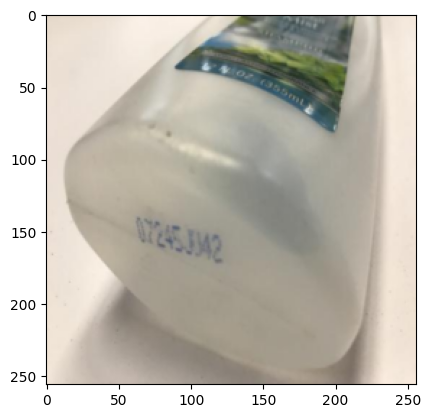

In [10]:
import random
img, label = dataset[random.randint(0, len(dataset))]
show_sample(img, label)

# Loading and Splitting Data:

In [11]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [12]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [13]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

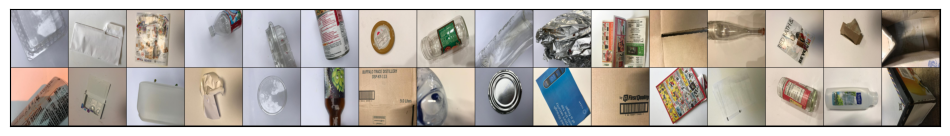

In [16]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [18]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(weights=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

C:\Users\legen\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
model = to_device(ResNet(), device)

In [24]:
evaluate(model, val_dl)

{'val_loss': 1.800401210784912, 'val_acc': 0.1302083283662796}

Let's start training the model:

In [25]:
epochs_count = 8
optimizer = torch.optim.Adam
learning_rate = 5.5e-5

history = fit(epochs_count, learning_rate, model, train_dl, val_dl, optimizer)

Epoch 1: train_loss: 1.4671, val_loss: 1.2833, val_acc: 0.8160
Epoch 2: train_loss: 1.1894, val_loss: 1.1706, val_acc: 0.9167
Epoch 3: train_loss: 1.0948, val_loss: 1.1380, val_acc: 0.9149
Epoch 4: train_loss: 1.0724, val_loss: 1.1280, val_acc: 0.9392
Epoch 5: train_loss: 1.0633, val_loss: 1.1123, val_acc: 0.9618
Epoch 6: train_loss: 1.0622, val_loss: 1.1209, val_acc: 0.9479
Epoch 7: train_loss: 1.0592, val_loss: 1.1053, val_acc: 0.9444
Epoch 8: train_loss: 1.0543, val_loss: 1.1108, val_acc: 0.9514


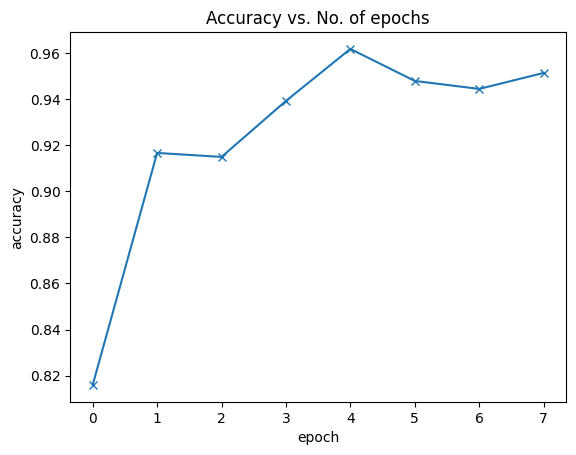

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

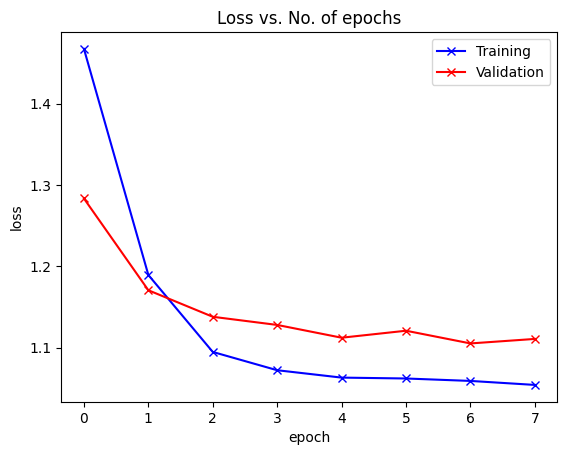

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Label: glass , Predicted: glass


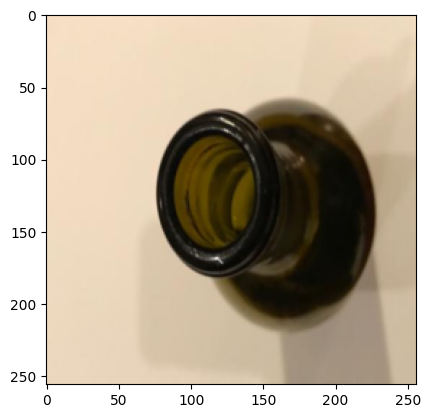

In [29]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


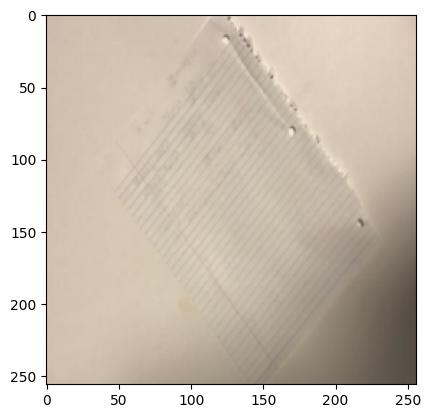

In [30]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


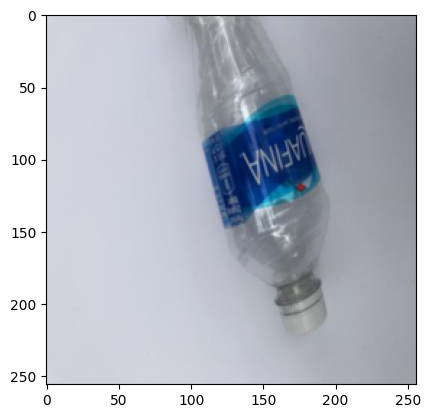

In [32]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [ ]:
# import urllib.request
# urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fengage.vic.gov.au%2Fapplication%2Ffiles%2F1415%2F0596%2F9236%2FDSC_0026.JPG&f=1&nofb=1", "plastic.jpg")
# urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fi.ebayimg.com%2Fimages%2Fi%2F291536274730-0-1%2Fs-l1000.jpg&f=1&nofb=1", "cardboard.jpg")    
# urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", "cans.jpg") 
# urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftinytrashcan.com%2Fwp-content%2Fuploads%2F2018%2F08%2Ftiny-trash-can-bulk-wine-bottle.jpg&f=1&nofb=1", "wine-trash.jpg")
# urllib.request.urlretrieve("http://ourauckland.aucklandcouncil.govt.nz/media/7418/38-94320.jpg", "paper-trash.jpg")

Let us load the model. You can load an external pre-trained model too!

In [35]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [33]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('external' + '/' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles metal.


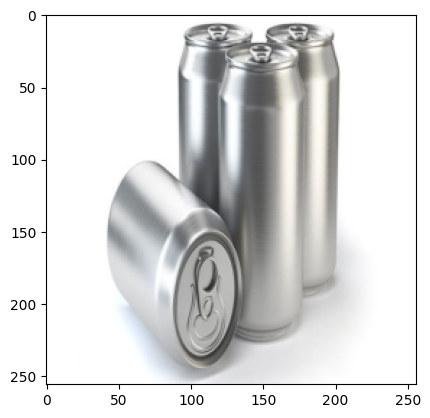

In [36]:
predict_external_image('cans.jpg')

The image resembles paper.


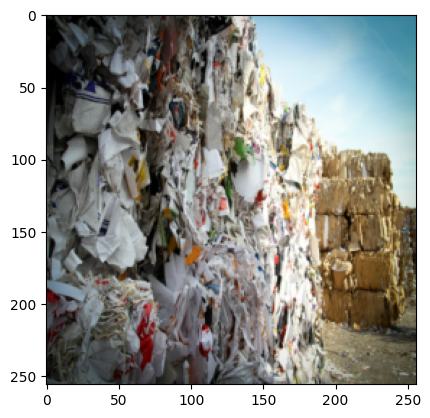

In [38]:
predict_external_image('RCP_illustration_1-scaled.jpg')

The image resembles cardboard.


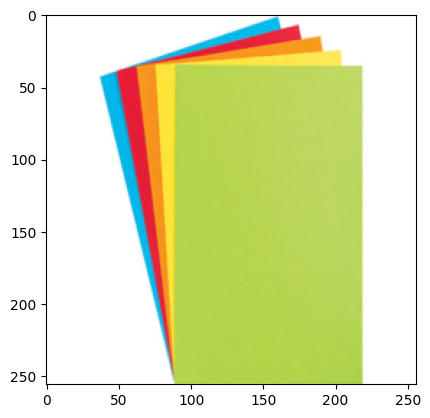

In [39]:
predict_external_image('cbz251.jpg')

The image resembles plastic.


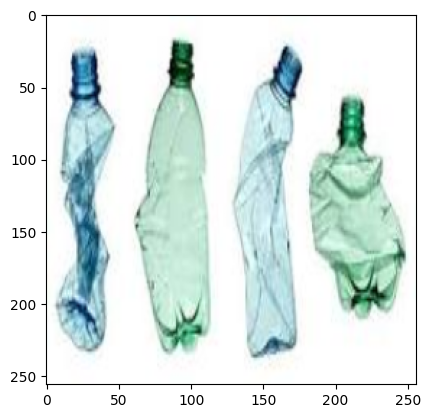

In [40]:
predict_external_image('plastics1.jpg')

The image resembles metal.


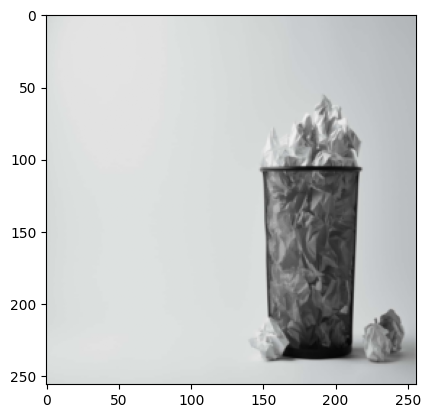

In [41]:
predict_external_image('Webp.net-resizeimage (12).jpg')

# Saving the Model:

Let's save the model for future use:

In [42]:
FILE = "models/acc95/model2.pth"
torch.save(model, FILE)

# Loading the Model:

Let's load the model:


In [43]:
model = torch.load(FILE)
model.eval()

for param in model.parameters():
    print(param)


Parameter containing:
tensor([[[[ 1.3496e-02,  1.4849e-02, -1.4987e-02,  ..., -4.0686e-02,
           -4.2949e-02, -7.0449e-02],
          [ 4.1208e-03,  5.7648e-03,  1.5038e-02,  ...,  2.0521e-03,
           -2.1129e-02, -3.8441e-02],
          [ 2.2359e-02,  2.3559e-02,  1.6153e-02,  ...,  1.0272e-01,
            6.2468e-02,  5.1943e-02],
          ...,
          [-8.4034e-04,  2.8023e-02, -9.8859e-03,  ..., -1.2728e-01,
           -7.6661e-02,  7.8905e-03],
          [ 3.6888e-03,  4.8339e-02,  6.2294e-02,  ...,  2.4118e-02,
           -3.3762e-02, -1.5601e-02],
          [-7.9932e-02, -3.1968e-02, -1.7548e-02,  ...,  3.5332e-02,
            2.2390e-02,  1.9184e-03]],

         [[-1.8182e-02,  1.1617e-02,  2.4233e-02,  ...,  5.3892e-02,
            4.4114e-02, -9.0799e-03],
          [-7.5898e-03,  1.9004e-02,  6.8244e-02,  ...,  1.5946e-01,
            1.4595e-01,  1.2013e-01],
          [-4.5846e-02, -7.5919e-02, -8.9454e-02,  ...,  1.2105e-01,
            1.6701e-01,  1.7632e-01]